<h3> Saifeddine Benzaied
<hr>
<h5> RT5
    

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

<b> Préparation des données

In [2]:
# Charger les données MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Préparer les données pour le VAE et le CAE
x_train_vae = np.reshape(x_train, (len(x_train), -1))  # Flatten pour le VAE
x_test_vae = np.reshape(x_test, (len(x_test), -1))
x_train_cae = np.expand_dims(x_train, axis=-1)  # Ajouter une dimension pour le CAE
x_test_cae = np.expand_dims(x_test, axis=-1)

input_dim = x_train_vae.shape[1]  # Dimension d'entrée pour le VAE (28*28 = 784)

<b> Fonctions et paramètres communs

In [3]:
# Fonction pour évaluer les modèles (VAE et CAE)
def evaluate_model(model, x_test, x_test_orig):
    reconstructed = model.predict(x_test)

    # Calcul des métriques
    mse_loss = MeanSquaredError()(x_test_orig, reconstructed).numpy()
    psnr_value = psnr(x_test_orig, reconstructed, data_range=1.0)
    ssim_value = np.mean([
        ssim(x.reshape(28, 28), y.reshape(28, 28), data_range=1.0)
        for x, y in zip(x_test_orig, reconstructed)
    ])

    # Afficher les 5 premières reconstructions
    for i in range(5):
        plt.figure(figsize=(4, 2))
        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(x_test_orig[i].reshape(28, 28), cmap='gray')
        plt.title("Input")
        plt.axis("off")
        # Reconstructed
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Output")
        plt.axis("off")
        plt.show()

    return {"MSE": mse_loss, "PSNR": psnr_value, "SSIM": ssim_value}

In [4]:
# Hyperparamètres à tester
latent_dims = [16, 32]
hidden_dims = [128, 256]

<hr>
<h4>Partie de VAE
<hr>

In [5]:
# Fonction pour créer le VAE
def create_vae(latent_dim, intermediate_dim):
    # Encodeur
    inputs = Input(shape=(input_dim,))
    h = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Échantillonnage
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Décodeur
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    outputs = decoder_mean(h_decoded)

    # VAE Model
    vae = Model(inputs, outputs)

    # Perte
    reconstruction_loss = MeanSquaredError()(inputs, outputs) * input_dim
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)

    # Compile
    vae.compile(optimizer='adam')
    return vae

  TRAINING VAE - Latent Dim: 16, Hidden Dim: 128  
Epoch 1/20
469/469 [==============================] - 10s 14ms/step - loss: 52.9097 - val_loss: 40.3804 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 38.1424 - val_loss: 36.1557 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 35.5675 - val_loss: 34.6602 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 34.3380 - val_loss: 33.6166 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 33.5370 - val_loss: 32.9013 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 33.0147 - val_loss: 32.4014 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 32.6190 - val_loss: 32.1768 - lr: 0.0010
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 32.3282 - val_loss: 31.8594 - lr: 0.0010
Epoch 9/20
469/469 [=======

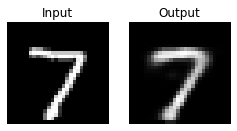

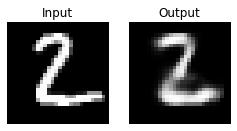

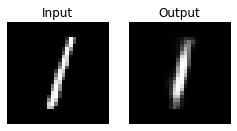

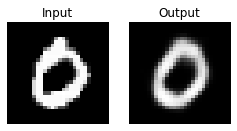

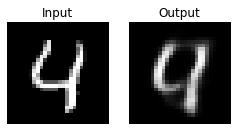

  TRAINING VAE - Latent Dim: 16, Hidden Dim: 256  
Epoch 1/20
469/469 [==============================] - 5s 9ms/step - loss: 49.4546 - val_loss: 38.4806 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 4s 8ms/step - loss: 36.3973 - val_loss: 34.7805 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 34.2132 - val_loss: 33.2197 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 33.0809 - val_loss: 32.4562 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 4s 8ms/step - loss: 32.4293 - val_loss: 31.8278 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 31.9741 - val_loss: 31.5570 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 31.6315 - val_loss: 31.2546 - lr: 0.0010
Epoch 8/20
469/469 [==============================] - 4s 8ms/step - loss: 31.4120 - val_loss: 31.0781 - lr: 0.0010
Epoch 9/20
469/469 [=========

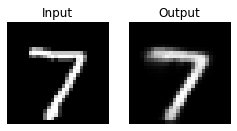

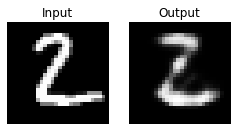

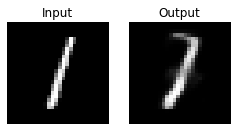

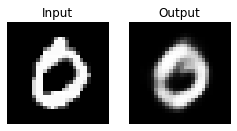

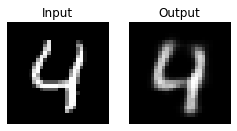

  TRAINING VAE - Latent Dim: 32, Hidden Dim: 128  
Epoch 1/20
469/469 [==============================] - 3s 5ms/step - loss: 53.5111 - val_loss: 42.1064 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 39.7758 - val_loss: 37.5986 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 2s 5ms/step - loss: 36.4994 - val_loss: 35.0791 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 34.7520 - val_loss: 33.9530 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 33.7700 - val_loss: 33.0649 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 33.1788 - val_loss: 32.6049 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 2s 5ms/step - loss: 32.7532 - val_loss: 32.2540 - lr: 0.0010
Epoch 8/20
469/469 [==============================] - 2s 5ms/step - loss: 32.4340 - val_loss: 31.9862 - lr: 0.0010
Epoch 9/20
469/469 [=========

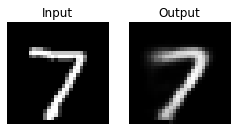

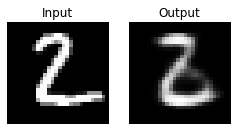

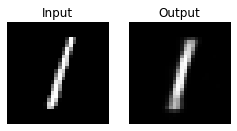

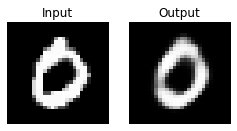

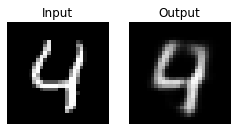

  TRAINING VAE - Latent Dim: 32, Hidden Dim: 256  
Epoch 1/20
469/469 [==============================] - 6s 10ms/step - loss: 49.6521 - val_loss: 39.5951 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 4s 9ms/step - loss: 37.4896 - val_loss: 35.4667 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 4s 8ms/step - loss: 34.7587 - val_loss: 33.7218 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 33.4482 - val_loss: 32.7339 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 32.7038 - val_loss: 32.1595 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 32.2210 - val_loss: 31.6631 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 31.8484 - val_loss: 31.4311 - lr: 0.0010
Epoch 8/20
469/469 [==============================] - 4s 9ms/step - loss: 31.6154 - val_loss: 31.2837 - lr: 0.0010
Epoch 9/20
469/469 [========

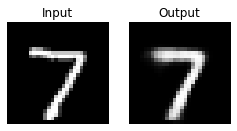

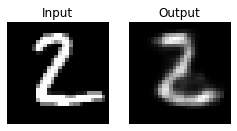

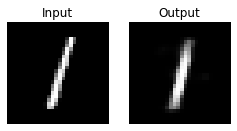

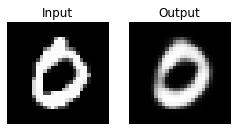

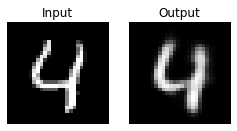

In [6]:
# Entraînement et évaluation pour le VAE
results_vae = []
for latent_dim in latent_dims:
    for hidden_dim in hidden_dims:
        
        print("\033[1;34m" + "="*50)
        print(f"TRAINING VAE - Latent Dim: {latent_dim}, Hidden Dim: {hidden_dim}".center(50))
        print("="*50 + "\033[0m")
        
        vae = create_vae(latent_dim, hidden_dim)

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        vae.fit(x_train_vae, x_train_vae,
                epochs=20, batch_size=128, verbose=1,
                validation_data=(x_test_vae, x_test_vae),
                callbacks=[reduce_lr, early_stopping])

        results = evaluate_model(vae, x_test_vae, x_test_vae)
        results["Latent Dim"] = latent_dim
        results["Hidden Dim"] = hidden_dim
        results_vae.append(results)

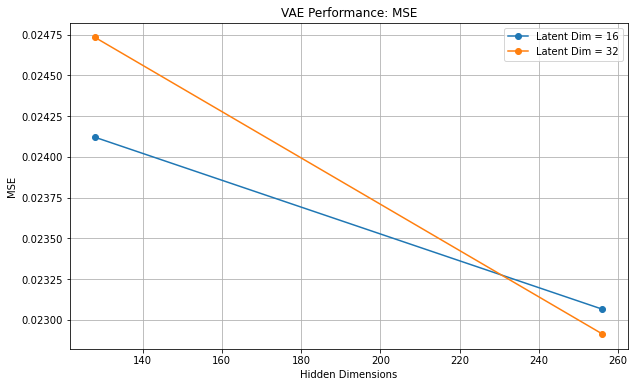

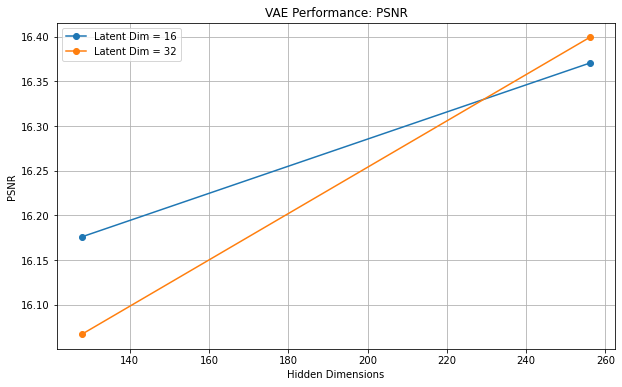

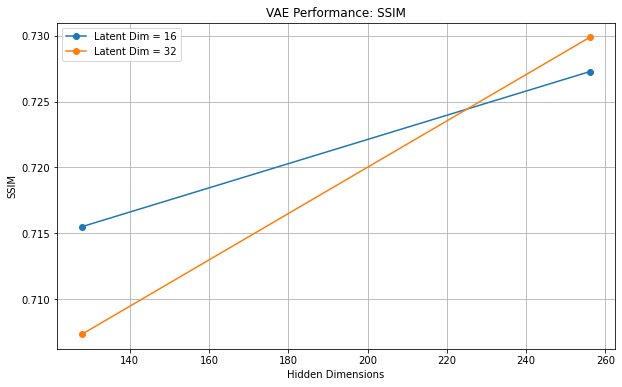

In [7]:
# Visualiser les métriques pour le VAE
results_df_vae = pd.DataFrame(results_vae)
for metric in ["MSE", "PSNR", "SSIM"]:
    plt.figure(figsize=(10, 6))
    for latent_dim in latent_dims:
        subset = results_df_vae[results_df_vae["Latent Dim"] == latent_dim]
        plt.plot(subset["Hidden Dim"], subset[metric], marker='o', label=f"Latent Dim = {latent_dim}")
    plt.title(f"VAE Performance: {metric}")
    plt.xlabel("Hidden Dimensions")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

<hr>
<h4>Partie de CAE
<hr>

In [8]:
# Fonction pour créer le CAE
def create_cae(latent_dim, intermediate_dim):
    # Encodeur
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))  # MNIST images (28, 28, 1)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    # Décodeur
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # CAE Model
    cae = Model(inputs, decoded)
    cae.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['mse'])
    return cae

  TRAINING CAE - Latent Dim: 16, Hidden Dim: 128  
Epoch 1/20
469/469 [==============================] - 111s 233ms/step - loss: 0.1281 - mse: 0.0219 - val_loss: 0.0787 - val_mse: 0.0059 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 109s 232ms/step - loss: 0.0765 - mse: 0.0051 - val_loss: 0.0733 - val_mse: 0.0042 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 111s 236ms/step - loss: 0.0729 - mse: 0.0040 - val_loss: 0.0713 - val_mse: 0.0035 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 111s 237ms/step - loss: 0.0712 - mse: 0.0034 - val_loss: 0.0699 - val_mse: 0.0032 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 109s 232ms/step - loss: 0.0701 - mse: 0.0031 - val_loss: 0.0689 - val_mse: 0.0029 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 108s 229ms/step - loss: 0.0692 - mse: 0.0029 - val_loss: 0.0689 - val_mse: 0.0028 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 1

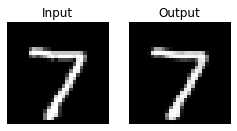

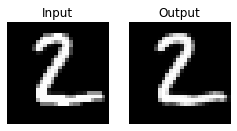

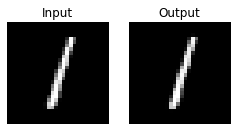

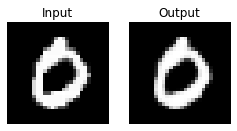

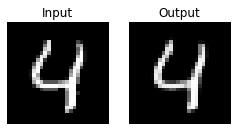

  TRAINING CAE - Latent Dim: 16, Hidden Dim: 256  
Epoch 1/20
469/469 [==============================] - 104s 219ms/step - loss: 0.1191 - mse: 0.0188 - val_loss: 0.0775 - val_mse: 0.0054 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 102s 218ms/step - loss: 0.0754 - mse: 0.0047 - val_loss: 0.0726 - val_mse: 0.0039 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 102s 218ms/step - loss: 0.0721 - mse: 0.0037 - val_loss: 0.0705 - val_mse: 0.0033 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 106s 225ms/step - loss: 0.0706 - mse: 0.0033 - val_loss: 0.0694 - val_mse: 0.0029 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 106s 226ms/step - loss: 0.0696 - mse: 0.0030 - val_loss: 0.0686 - val_mse: 0.0027 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 105s 224ms/step - loss: 0.0689 - mse: 0.0028 - val_loss: 0.0681 - val_mse: 0.0026 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 1

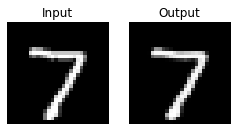

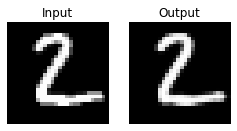

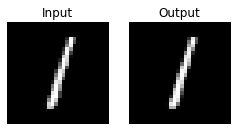

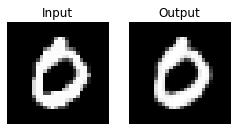

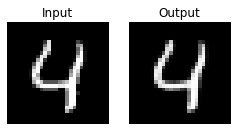

  TRAINING CAE - Latent Dim: 32, Hidden Dim: 128  
Epoch 1/20
469/469 [==============================] - 106s 224ms/step - loss: 0.1253 - mse: 0.0208 - val_loss: 0.0814 - val_mse: 0.0067 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 104s 222ms/step - loss: 0.0787 - mse: 0.0057 - val_loss: 0.0753 - val_mse: 0.0048 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 104s 222ms/step - loss: 0.0748 - mse: 0.0045 - val_loss: 0.0734 - val_mse: 0.0042 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 104s 223ms/step - loss: 0.0727 - mse: 0.0039 - val_loss: 0.0711 - val_mse: 0.0035 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 103s 220ms/step - loss: 0.0713 - mse: 0.0034 - val_loss: 0.0699 - val_mse: 0.0031 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 104s 221ms/step - loss: 0.0702 - mse: 0.0031 - val_loss: 0.0697 - val_mse: 0.0031 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 1

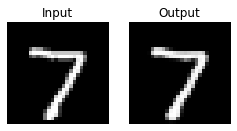

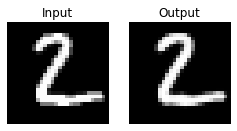

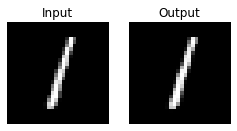

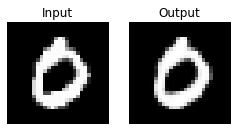

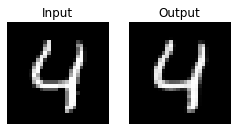

  TRAINING CAE - Latent Dim: 32, Hidden Dim: 256  
Epoch 1/20
469/469 [==============================] - 106s 223ms/step - loss: 0.1203 - mse: 0.0192 - val_loss: 0.0783 - val_mse: 0.0056 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 104s 222ms/step - loss: 0.0760 - mse: 0.0049 - val_loss: 0.0730 - val_mse: 0.0041 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 104s 222ms/step - loss: 0.0728 - mse: 0.0039 - val_loss: 0.0711 - val_mse: 0.0035 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 105s 224ms/step - loss: 0.0711 - mse: 0.0034 - val_loss: 0.0701 - val_mse: 0.0032 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 105s 223ms/step - loss: 0.0701 - mse: 0.0031 - val_loss: 0.0690 - val_mse: 0.0028 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 104s 222ms/step - loss: 0.0693 - mse: 0.0029 - val_loss: 0.0685 - val_mse: 0.0027 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 1

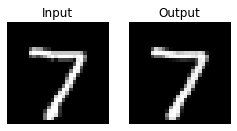

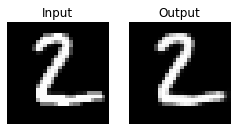

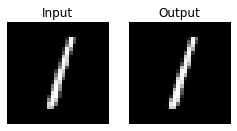

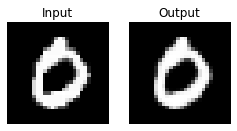

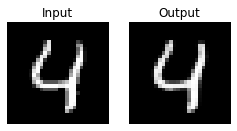

In [9]:
# Entraînement et évaluation pour le CAE
results_cae = []
for latent_dim in latent_dims:
    for hidden_dim in hidden_dims:
        
        print("\033[1;32m" + "="*50)
        print(f"TRAINING CAE - Latent Dim: {latent_dim}, Hidden Dim: {hidden_dim}".center(50))
        print("="*50 + "\033[0m")
        
        cae = create_cae(latent_dim, hidden_dim)

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        cae.fit(x_train_cae, x_train_cae,
                epochs=20, batch_size=128, verbose=1,
                validation_data=(x_test_cae, x_test_cae),
                callbacks=[reduce_lr, early_stopping])

        results = evaluate_model(cae, x_test_cae, x_test_cae)
        results["Latent Dim"] = latent_dim
        results["Hidden Dim"] = hidden_dim
        results_cae.append(results)

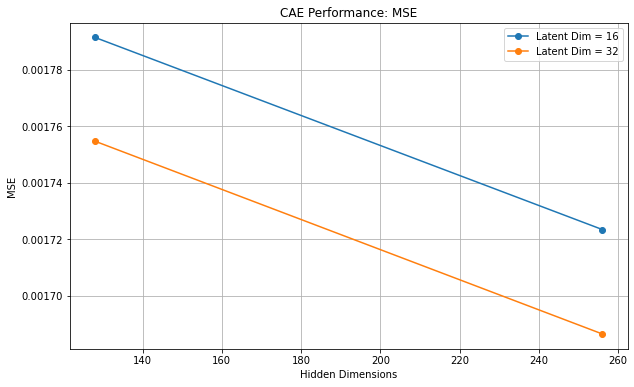

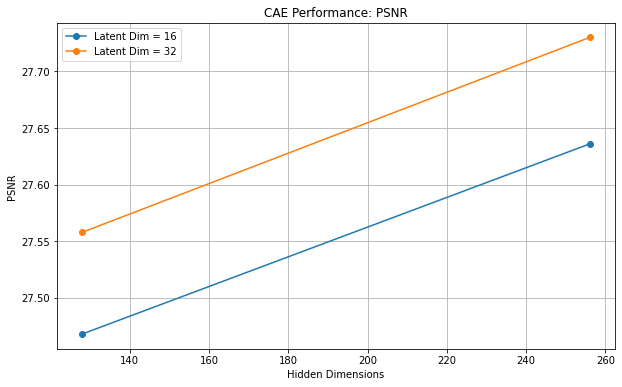

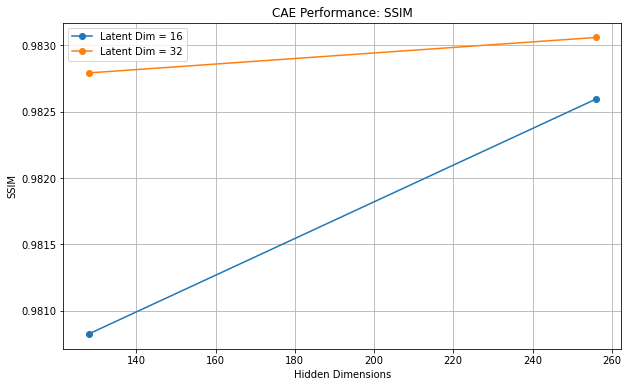

In [10]:
# Visualiser les métriques pour le CAE
results_df_cae = pd.DataFrame(results_cae)
for metric in ["MSE", "PSNR", "SSIM"]:
    plt.figure(figsize=(10, 6))
    for latent_dim in latent_dims:
        subset = results_df_cae[results_df_cae["Latent Dim"] == latent_dim]
        plt.plot(subset["Hidden Dim"], subset[metric], marker='o', label=f"Latent Dim = {latent_dim}")
    plt.title(f"CAE Performance: {metric}")
    plt.xlabel("Hidden Dimensions")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()